<a href="https://colab.research.google.com/github/am610/GWCCSN_EOS_Ye/blob/main/18_EoS_NN_Fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### @AyanMitra, 2023
##### This is the notebook with -10, +49 ms, and Ye varying dataset
#### In this notebook we explore the Fourier space data. We also generate the Fourier dataset with and without transformation for the -10,+49 ms dataset. Lower down in the notebook we comoute the NN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# @title
from sklearn import metrics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm,Normalize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# drive.mount('/content/drive')
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, windows, spectrogram
from numpy.fft import fft, fftshift, fftfreq
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_signal(df, row_number):
    # Get the time, signal, and label data for the specified row
    midpoint = int((df.shape[1] - 1) / 2)
    time_data = df.iloc[row_number, :midpoint]
    signal_data = df.iloc[row_number, midpoint:-1]  # excluding the label column
    label = df.iloc[row_number, -1]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, signal_data, label=f'Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.title(f'Signal vs Time for row {row_number}')
    plt.legend()

    # Display the plot
    #plt.show()

def plot_two_signals(df1, df2, row):
    # Get the time, signal, and label data for the specified rows
    midpoint1 = int((df1.shape[1] - 1) / 2)
    time_data1 = df1.iloc[row, :midpoint1]
    signal_data1 = df1.iloc[row, midpoint1:-1]  # excluding the label column
    label1 = df1.iloc[row, -1]

    midpoint2 = int((df2.shape[1] - 1) / 2)
    time_data2 = df2.iloc[row, :midpoint2]
    signal_data2 = df2.iloc[row, midpoint2:-1]  # excluding the label column
    label2 = df2.iloc[row, -1]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_data1, signal_data1,color='r', label=f'Label 1: {label1}')
    plt.plot(time_data2, signal_data2,color='b', label=f'Label 2: {label2}')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.title(f'Signal vs Time for row {row}')
    plt.legend()

    # Display the plot
    plt.show()

def filter_dataframe(df, start_time, end_time):
    """
    Filter a dataframe based on a specified time range.

    Args:
    df (pd.DataFrame): The input dataframe.
    start_time (float): The start of the time range.
    end_time (float): The end of the time range.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """

    # Determine the mid-point of the columns (excluding the 'Label' column)
    mid_point = int((df.shape[1] - 1) / 2)

    # Create a mask for filtering the columns
    mask = (df.iloc[0, :mid_point] >= start_time) & (df.iloc[0, :mid_point] <= end_time)

    # Filter the time and signal columns based on the mask, and concatenate with the 'Label' column
    time_filtered = df.iloc[:, :mid_point].values[:, mask.values]
    signal_filtered = df.iloc[:, mid_point:-1].values[:, mask.values]

    # Convert these arrays back to dataframes
    time_df = pd.DataFrame(time_filtered)
    signal_df = pd.DataFrame(signal_filtered)

    df_filtered = pd.concat([time_df, signal_df, df['Label'].reset_index(drop=True)], axis=1)

    return df_filtered


def filter_dataframe2(df, start_time, end_time, num_points):
    """
    Filter a dataframe based on a specified time range and return a specified number of datapoints.

    Args:
    df (pd.DataFrame): The input dataframe.
    start_time (float): The start of the time range.
    end_time (float): The end of the time range.
    num_points (int): The number of datapoints to return.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """

    # Determine the mid-point of the columns (excluding the 'Label' column)
    mid_point = int((df.shape[1] - 1) / 2)

    # Create a mask for filtering the columns
    mask = (df.iloc[0, :mid_point] >= start_time) & (df.iloc[0, :mid_point] <= end_time)

    # Filter the time and signal columns based on the mask
    time_filtered = df.iloc[:, :mid_point].values[:, mask.values]
    signal_filtered = df.iloc[:, mid_point:-1].values[:, mask.values]

    # Convert these arrays back to dataframes
    time_df = pd.DataFrame(time_filtered)
    signal_df = pd.DataFrame(signal_filtered)

    # Concatenate to get the filtered dataframe without the 'Label' column
    df_filtered = pd.concat([time_df, signal_df], axis=1)

    # Calculate the step size based on the total number of points and the desired number of points
    step_size = max(1, int(df_filtered.shape[1] / num_points))

    # Select every nth column based on the step size
    df_selected = df_filtered.iloc[:, ::step_size]

    # Add the 'Label' column separately to ensure it's included in the final output
    df_selected = pd.concat([df_selected, df['Label'].reset_index(drop=True)], axis=1)

    return df_selected

# Define a function to calculate min and max Fourier frequencies for each row
def min_max_fft_freqs(row):
    N = len(row)
    sample_frequencies = fftshift(fftfreq(N, d=(time_data[1]-time_data[0])))
    return pd.Series([sample_frequencies.min(), sample_frequencies.max()], index=['Min FFT Frequency', 'Max FFT Frequency'])

# 3. Computing the Fourier magnitudes for each row in the original_data
def compute_fourier_magnitudes(row):
    spectrum = fftshift(fft(row))
    return np.abs(spectrum)


In [7]:
data = pd.read_csv('/content/drive/MyDrive/data_18eos_10_49.csv')

In [4]:
np.shape(data)

(1350, 1181)

In [64]:
# @title
# One time execution to create the Fourier DF
'''
import pandas as pd
import numpy as np
from numpy.fft import fftfreq, fft, fftshift


# Extracting the time and original data columns
midpoint = len(data.columns) // 2
time_data = data.iloc[:, :midpoint].mean()
original_data = data.iloc[:, midpoint:-1]  # excluding the label column
original_data = 2.0/len(original_data) * original_data


# Computing the Fourier frequencies
N = len(time_data)
sample_frequencies = fftshift(fftfreq(N, d=(time_data[1]-time_data[0])))

# Computing the Fourier magnitudes
fourier_magnitudes = original_data.apply(compute_fourier_magnitudes, axis=1, result_type='expand')

# Resetting the column names to simple numbers for the Fourier magnitudes dataframe
fourier_magnitudes.columns = list(range(1, fourier_magnitudes.shape[1] + 1))

# Constructing the dataframe with frequencies as the first row
fourier_df_with_freq = pd.concat([pd.DataFrame([sample_frequencies], columns=fourier_magnitudes.columns), fourier_magnitudes], ignore_index=True)

# Adding the 'Label' column
fourier_df_with_freq['Label'] = ['Frequency'] + data['Label'].tolist()

# Saving to CSV with modified column names and frequency values as first row
save_path_with_modified_columns = "/content/drive/MyDrive/data_18eos_10_49_Fourier.csv"
fourier_df_with_freq.to_csv(save_path_with_modified_columns, index=False)
''';

In [63]:
# @title
'''
# Extracting the time and original data columns
midpoint = len(data.columns) // 2
time_data = data.iloc[:, :midpoint].mean()
original_data = data.iloc[:, midpoint:-1]  # excluding the label column
original_data = 2.0/len(original_data) * original_data

# 2.2 Transformed Data
alpha = 0.1
window = windows.tukey(M=original_data.shape[1], alpha=alpha)
windowed_data = original_data.multiply(window, axis=1)
order = 10
attenuation = 0.25
b, a = butter(order, attenuation, btype='low')
filtered_data = windowed_data.apply(lambda x: filtfilt(b, a, x), axis=1)

# Convert the Series to a DataFrame
filtered_data_df = pd.DataFrame(filtered_data.tolist(), columns=time_data.index)
original_data = filtered_data_df

# Computing the Fourier frequencies
N = len(time_data)
sample_frequencies = fftshift(fftfreq(N, d=(time_data[1]-time_data[0])))

# Computing the Fourier magnitudes
fourier_magnitudes = original_data.apply(compute_fourier_magnitudes, axis=1, result_type='expand')

# Resetting the column names to simple numbers for the Fourier magnitudes dataframe
fourier_magnitudes.columns = list(range(1, fourier_magnitudes.shape[1] + 1))

# Constructing the dataframe with frequencies as the first row
fourier_df_with_freq = pd.concat([pd.DataFrame([sample_frequencies], columns=fourier_magnitudes.columns), fourier_magnitudes], ignore_index=True)

# Adding the 'Label' column
fourier_df_with_freq['Label'] = ['Frequency'] + data['Label'].tolist()

# Saving to CSV with modified column names and frequency values as first row
save_path_with_modified_columns = "/content/drive/MyDrive/data_18eos_10_49_Fourier_Transformed.csv"
fourier_df_with_freq.to_csv(save_path_with_modified_columns, index=False)
''';

In [82]:
fourier_df_with_freq = pd.read_csv('/content/drive/MyDrive/data_18eos_10_49_Fourier.csv')
fourier_df_with_trans = pd.read_csv('/content/drive/MyDrive/data_18eos_10_49_Fourier_Transformed.csv')

In [41]:
np.shape(fourier_df_with_freq)

(1351, 591)

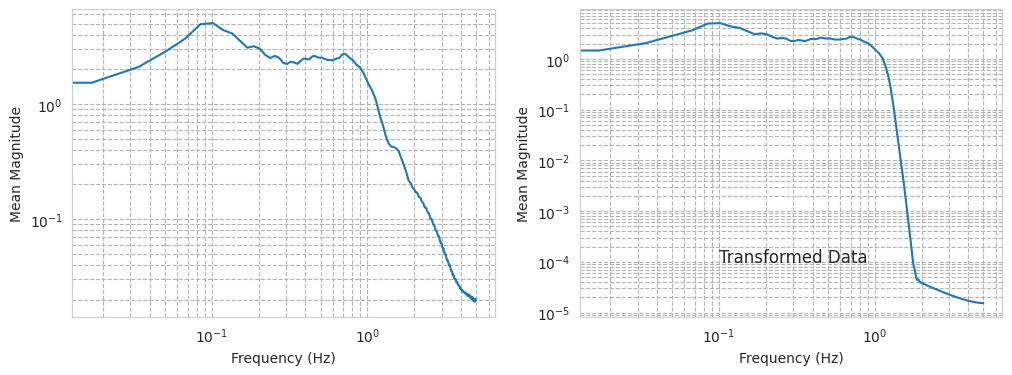

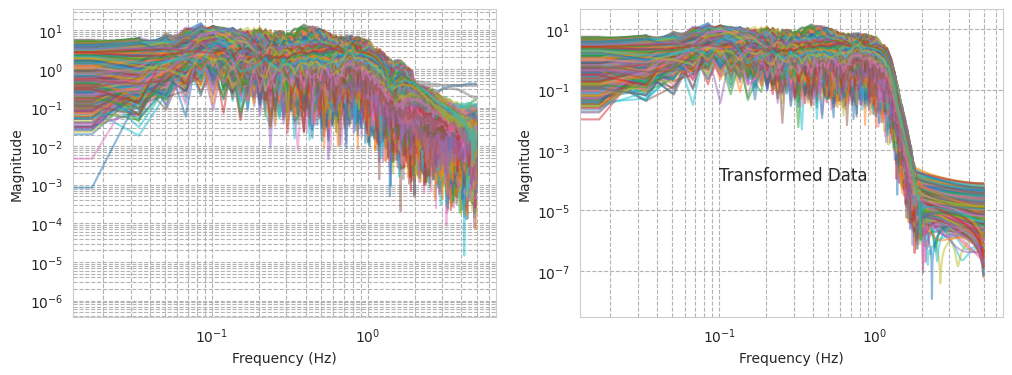

In [71]:
# @title

# Excluding the 'Frequency' and 'Label' columns
df_to_plot = fourier_df_with_freq.drop(index=0).drop(columns='Label').astype(float)
df_to_plot2 = fourier_df_with_trans.drop(index=0).drop(columns='Label').astype(float)

# Taking the mean of all rows for plotting
mean_magnitude = df_to_plot.mean()
mean_magnitude2 = df_to_plot2.mean()

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.loglog(sample_frequencies, mean_magnitude)
#plt.title('Mean Fourier Magnitude vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Magnitude')
plt.grid(True, which="both", ls="--", c='0.7')


plt.subplot(1,2,2)
plt.loglog(sample_frequencies, mean_magnitude2)
#plt.title('Mean Fourier Magnitude vs Frequency Transformed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Magnitude')
plt.text(0.1,0.0001,'Transformed Data',fontsize=12)
plt.grid(True, which="both", ls="--", c='0.7')

plt.show()


# Plotting all rows

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
# Plotting each row
for index, row in df_to_plot.iterrows():
    plt.loglog(sample_frequencies, row, alpha=0.5)

#plt.title('Fourier Magnitude vs Frequency for All Rows')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, which="both", ls="--", c='0.7')

plt.subplot(1,2,2)
# Plotting each row
for index, row in df_to_plot2.iterrows():
    plt.loglog(sample_frequencies, row, alpha=0.5)

#plt.title('Fourier Magnitude vs Frequency for All Rows')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.text(0.1,0.0001,'Transformed Data',fontsize=12)
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()


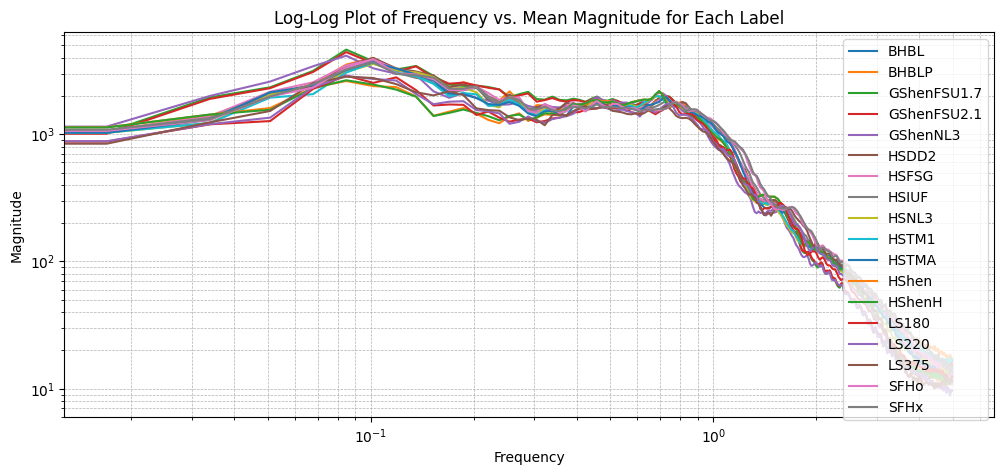

In [53]:
# @title
fourier_df_with_freq = pd.read_csv('/content/drive/MyDrive/data_18eos_10_49_Fourier.csv')
# Extract frequency and drop the row from the dataframe
frequency = fourier_df_with_freq.iloc[0, :-1].values
fourier_df_with_freq = fourier_df_with_freq.drop(0)

# Compute mean curves for each label and plot
plt.figure(figsize=(12, 5))

for label, group in fourier_df_with_freq.groupby("Label"):
    mean_curve = group.drop(columns="Label").mean()
    plt.loglog(frequency, mean_curve, label=label)

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Log-Log Plot of Frequency vs. Mean Magnitude for Each Label")
plt.legend(loc='upper right')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

<ipython-input-73-d382f909179f>:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap, ticks=np.linspace(0, len(unique_labels) - 1, len(unique_labels)))


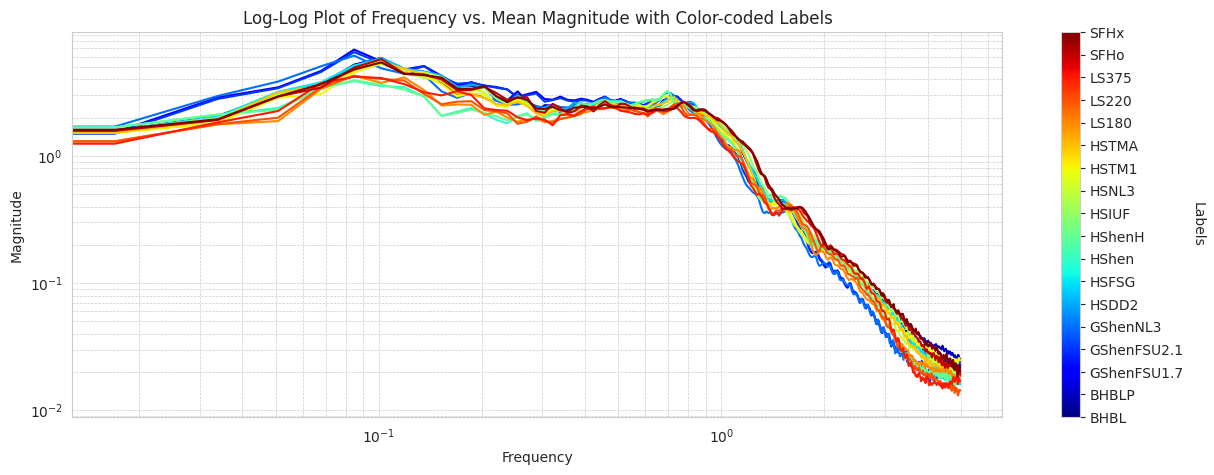

<ipython-input-73-d382f909179f>:64: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap, ticks=np.linspace(0, len(unique_labels) - 1, len(unique_labels)))


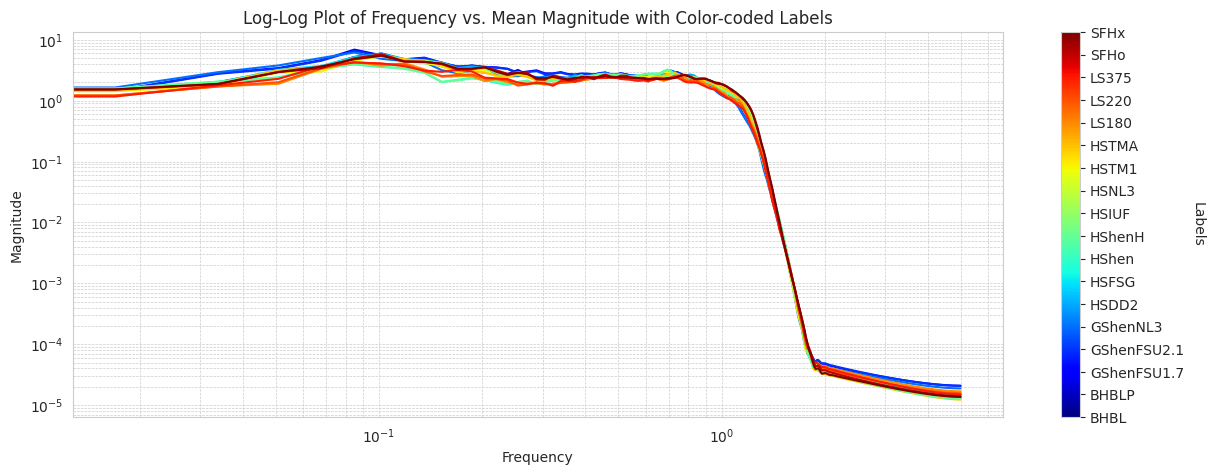

In [73]:
# @title


# Load the dataset
fourier_df_with_freq = pd.read_csv("/content/drive/MyDrive/data_18eos_10_49_Fourier.csv")

# Extract frequency and drop the row from the dataframe
frequency = fourier_df_with_freq.iloc[0, :-1].values
fourier_df_with_freq = fourier_df_with_freq.drop(0)

# Assign unique colors to each label using colormap
unique_labels = fourier_df_with_freq['Label'].unique()
colors = cm.jet(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Map each unique label to a numeric value
label_to_numeric = {label: idx for idx, label in enumerate(unique_labels)}
fourier_df_with_freq["Label_numeric"] = fourier_df_with_freq["Label"].map(label_to_numeric)

# Plotting
#plt.subplot(2,1,1)
plt.figure(figsize=(15, 5))
for label, group in fourier_df_with_freq.groupby("Label"):
    mean_curve = group.drop(columns=["Label", "Label_numeric"]).mean()
    plt.loglog(frequency, mean_curve, color=label_to_color[label])

# Adding colorbar
cmap = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(0, len(unique_labels) - 1))
cbar = plt.colorbar(cmap, ticks=np.linspace(0, len(unique_labels) - 1, len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
cbar.set_label('Labels', rotation=270, labelpad=15)

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Log-Log Plot of Frequency vs. Mean Magnitude with Color-coded Labels")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()





# Load the dataset
fourier_df_with_freq = pd.read_csv("/content/drive/MyDrive/data_18eos_10_49_Fourier_Transformed.csv")

# Extract frequency and drop the row from the dataframe
frequency = fourier_df_with_freq.iloc[0, :-1].values
fourier_df_with_freq = fourier_df_with_freq.drop(0)

# Assign unique colors to each label using colormap
unique_labels = fourier_df_with_freq['Label'].unique()
colors = cm.jet(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Map each unique label to a numeric value
label_to_numeric = {label: idx for idx, label in enumerate(unique_labels)}
fourier_df_with_freq["Label_numeric"] = fourier_df_with_freq["Label"].map(label_to_numeric)

# Plotting
plt.figure(figsize=(15, 5))
for label, group in fourier_df_with_freq.groupby("Label"):
    mean_curve = group.drop(columns=["Label", "Label_numeric"]).mean()
    plt.loglog(frequency, mean_curve, color=label_to_color[label])

# Adding colorbar
cmap = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(0, len(unique_labels) - 1))
cbar = plt.colorbar(cmap, ticks=np.linspace(0, len(unique_labels) - 1, len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
cbar.set_label('Labels', rotation=270, labelpad=15)

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Log-Log Plot of Frequency vs. Mean Magnitude with Color-coded Labels")
plt.grid(which='both', linestyle='--', linewidth=0.5)
#plt.show()

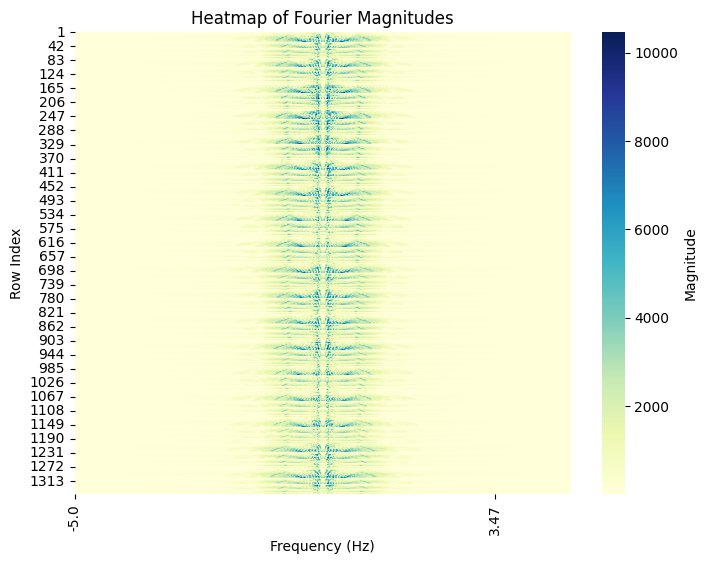

In [45]:
# @title
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_to_plot, cmap="YlGnBu", cbar_kws={'label': 'Magnitude'})
plt.title('Heatmap of Fourier Magnitudes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Row Index')
plt.xticks(ticks=list(range(0, len(sample_frequencies), 500)), labels=[round(f, 2) for f in sample_frequencies[::500]])  # showing every 500th frequency for clarity
plt.show()

'''
# Boxplot (for a subset of frequencies for clarity)
subset_frequencies_for_boxplot = sample_frequencies[::50]  # Taking every 50th frequency for clarity
subset_df = df_to_plot[subset_frequencies_for_boxplot]

plt.figure(figsize=(15, 8))
sns.boxplot(data=subset_df)
plt.title('Boxplot of Fourier Magnitudes for Selected Frequencies')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
''';


<ipython-input-81-e26b9e6daef0>:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation='vertical', label='Frequency (Hz)')


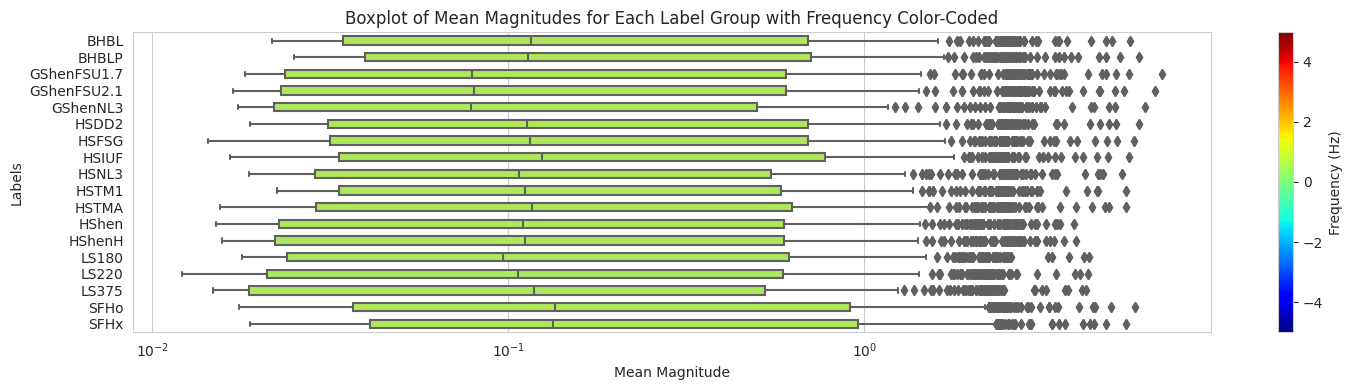

In [81]:
# @title
# Full code from reading the file to plotting the boxplot with 'jet' colormap

# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#data = pd.read_csv("/content/drive/MyDrive/data_18eos_10_49_Fourier_Transformed.csv")
data = pd.read_csv("/content/drive/MyDrive/data_18eos_10_49_Fourier.csv")

# Extract frequency values and drop the row from the dataframe
frequency_values = data.iloc[0, :-1].values
data = data.drop(0).reset_index(drop=True)

# Compute mean magnitudes for each frequency, grouped by label
mean_values = data.groupby("Label").mean()

# Transpose the mean values to prepare for boxplot
box_data_for_labels = mean_values.transpose()

# Compute the mean frequency for each label group
mean_frequencies = data.drop(columns="Label").mean(axis=1)
data["Mean_Frequency"] = mean_frequencies

# Map these mean frequencies to a color palette using 'jet' colormap
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(frequency_values), max(frequency_values))
colors = cmap(norm(data.groupby("Label")["Mean_Frequency"].mean()))

# Set Seaborn style
sns.set_style("whitegrid")

# Plotting using Seaborn with color-coded boxes
plt.figure(figsize=(15, 4))
sns.boxplot(data=box_data_for_labels, orient="h", width=0.5, palette=colors)

# Adding a colorbar to represent the frequency
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, orientation='vertical', label='Frequency (Hz)')
plt.xscale("log")
plt.xlabel("Mean Magnitude")
plt.ylabel("Labels")
plt.title("Boxplot of Mean Magnitudes for Each Label Group with Frequency Color-Coded")
plt.tight_layout()
plt.show()


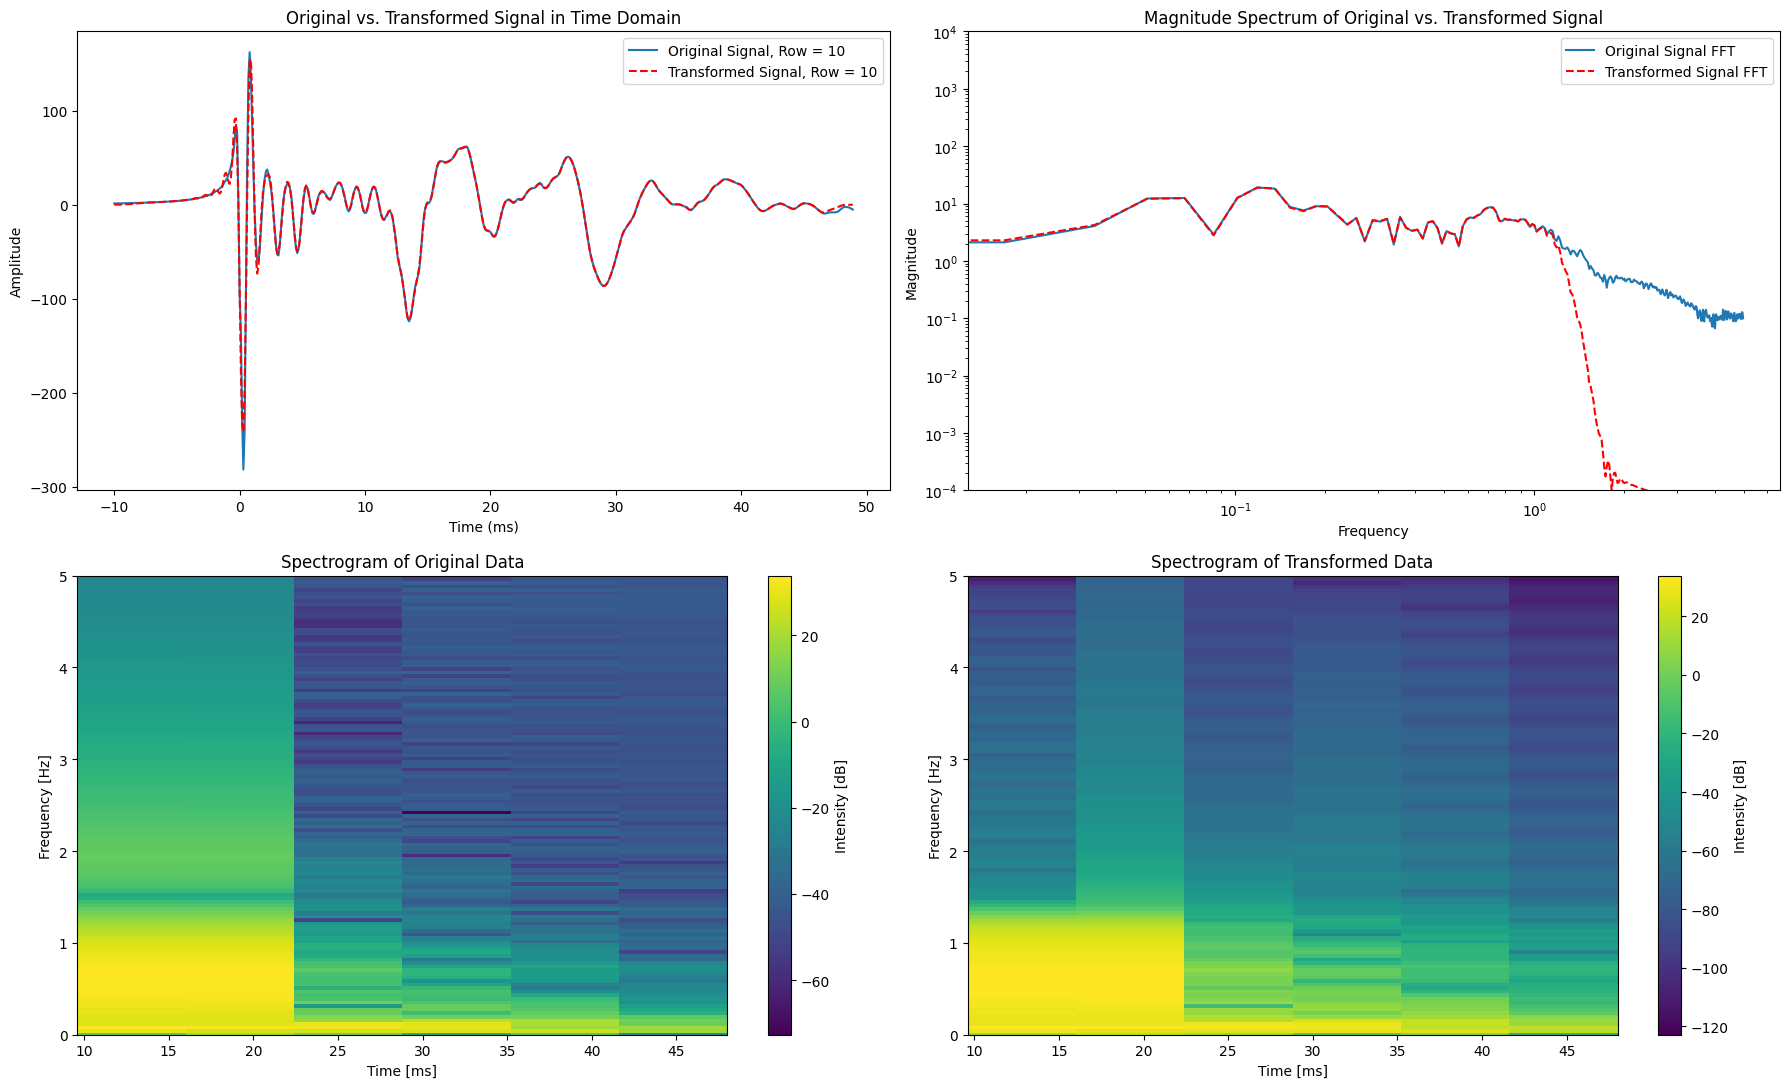

In [8]:
# @title
# Define the midpoint
midpoint = len(data.columns) // 2

# Choosing the first row from the original dataset for demonstration
N = 10
row_original = data.iloc[N]
time_original = np.array(row_original[:midpoint], dtype=float)
original_signal = np.array(row_original[midpoint:-1], dtype=float)  # excluding the label column

# Apply the Tukey window to this specific row
window = windows.tukey(M=len(original_signal), alpha=0.1)
windowed_signal = original_signal * window

# Design a low-pass Butterworth filter
order = 10
attenuation = 0.25
b, a = butter(order, attenuation, btype='low')

# Apply the Butterworth filter to the windowed signal
transformed_signal = filtfilt(b, a, windowed_signal)

# Compute the FFTs
original_fft = fftshift(fft(original_signal))
transformed_fft = fftshift(fft(transformed_signal))

# Normalize
spectrum1 = 2.0/len(original_signal) * original_fft
spectrum2 = 2.0/len(transformed_signal) * transformed_fft

# Compute the frequencies for original data
frequencies_original = fftfreq(len(spectrum1), d=(time_original[1]-time_original[0]))
frequencies_original = fftshift(frequencies_original)

# Spectrogram analysis for entire dataset
time_data = data.iloc[:, :midpoint].mean()
original_spectrogram_data = data.iloc[:, midpoint:-1]

# Apply Tukey window and Butterworth filter to each signal in the dataset
transformed_spectrogram_data = original_spectrogram_data.apply(lambda x: filtfilt(b, a, x * window), axis=1)

# Compute the spectrograms
frequencies, times, Sxx_original = spectrogram(original_spectrogram_data.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=256, noverlap=192)
_, _, Sxx_transformed = spectrogram(transformed_spectrogram_data.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=256, noverlap=192)

# Plotting
plt.figure(figsize=(18, 16))

# Overlay time domain signals
plt.subplot(3, 2, 1)
plt.plot(time_original, original_signal, label="Original Signal, Row = %s"%N)
plt.plot(time_original, transformed_signal, linestyle='--', label="Transformed Signal, Row = %s"%N, color='r')
plt.title('Original vs. Transformed Signal in Time Domain')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()

# Overlay frequency domain signals
plt.subplot(3, 2, 2)
plt.plot(frequencies_original, np.abs(spectrum1), label='Original Signal FFT')
plt.plot(frequencies_original, np.abs(spectrum2), linestyle='--', label='Transformed Signal FFT', color='r')
plt.title('Magnitude Spectrum of Original vs. Transformed Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e4)
plt.legend()

# Spectrogram of original data
plt.subplot(3, 2, 3)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_original), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Original Data')
plt.ylim(frequencies.min(), frequencies.max())


# Spectrogram of transformed data
plt.subplot(3, 2, 4)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_transformed), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Transformed Data')
plt.ylim(frequencies.min(), frequencies.max())


plt.tight_layout()
plt.show()


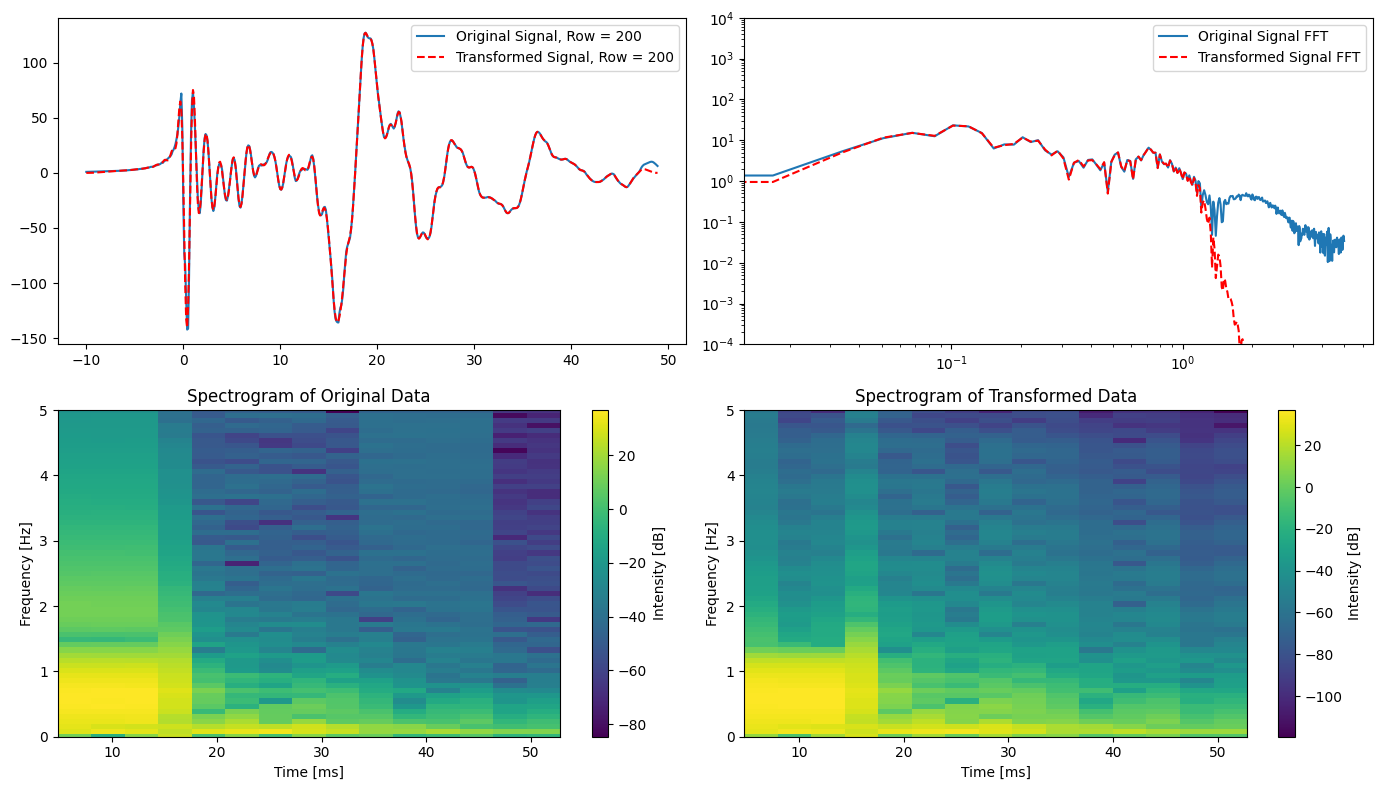

In [11]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 2. Data Transformation
# 2.1 Original Data
midpoint = len(data.columns) // 2
time_data = data.iloc[:, :midpoint].mean()
original_data = data.iloc[:, midpoint:-1]  # excluding the label column

# 2.2 Transformed Data
alpha = 0.1
window = windows.tukey(M=original_data.shape[1], alpha=alpha)
windowed_data = original_data.multiply(window, axis=1)
order = 10
attenuation = 0.25
b, a = butter(order, attenuation, btype='low')
filtered_data = windowed_data.apply(lambda x: filtfilt(b, a, x), axis=1)

# 3. Fourier Transformation
# Taking one representative row (e.g., the first row) from both datasets
N = 200
sample_original = original_data.iloc[N]
sample_transformed = filtered_data.iloc[N]
sample_frequencies = fftshift(fftfreq(len(sample_original), d=(time_data[1]-time_data[0])))
sample_spectrum1 = 2.0/len(sample_original) * fftshift(fft(sample_original))
sample_spectrum2 = 2.0/len(sample_transformed) * fftshift(fft(sample_transformed))

# 4. Spectrogram Analysis
frequencies, times, Sxx_original = spectrogram(original_data.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=128, noverlap=96)
_, _, Sxx_transformed = spectrogram(filtered_data.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=128, noverlap=96)



# Plotting
# Fourier Transformation plots
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(time_data, sample_original, label="Original Signal, Row = %s"%N)
plt.plot(time_data, sample_transformed, linestyle='--', label="Transformed Signal, Row = %s"%N, color='r')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(sample_frequencies, np.abs(sample_spectrum1), label='Original Signal FFT')
plt.plot(sample_frequencies, np.abs(sample_spectrum2), linestyle='--', label='Transformed Signal FFT', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e4)
plt.legend()

# Spectrogram plots
plt.subplot(2, 2, 3)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_original), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Original Data')
#plt.ylim(0, 1)
plt.ylim(frequencies.min(), frequencies.max())

plt.subplot(2, 2, 4)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx_transformed), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Transformed Data')
#plt.ylim(0, 1)
plt.ylim(frequencies.min(), frequencies.max())
plt.tight_layout()
plt.show()

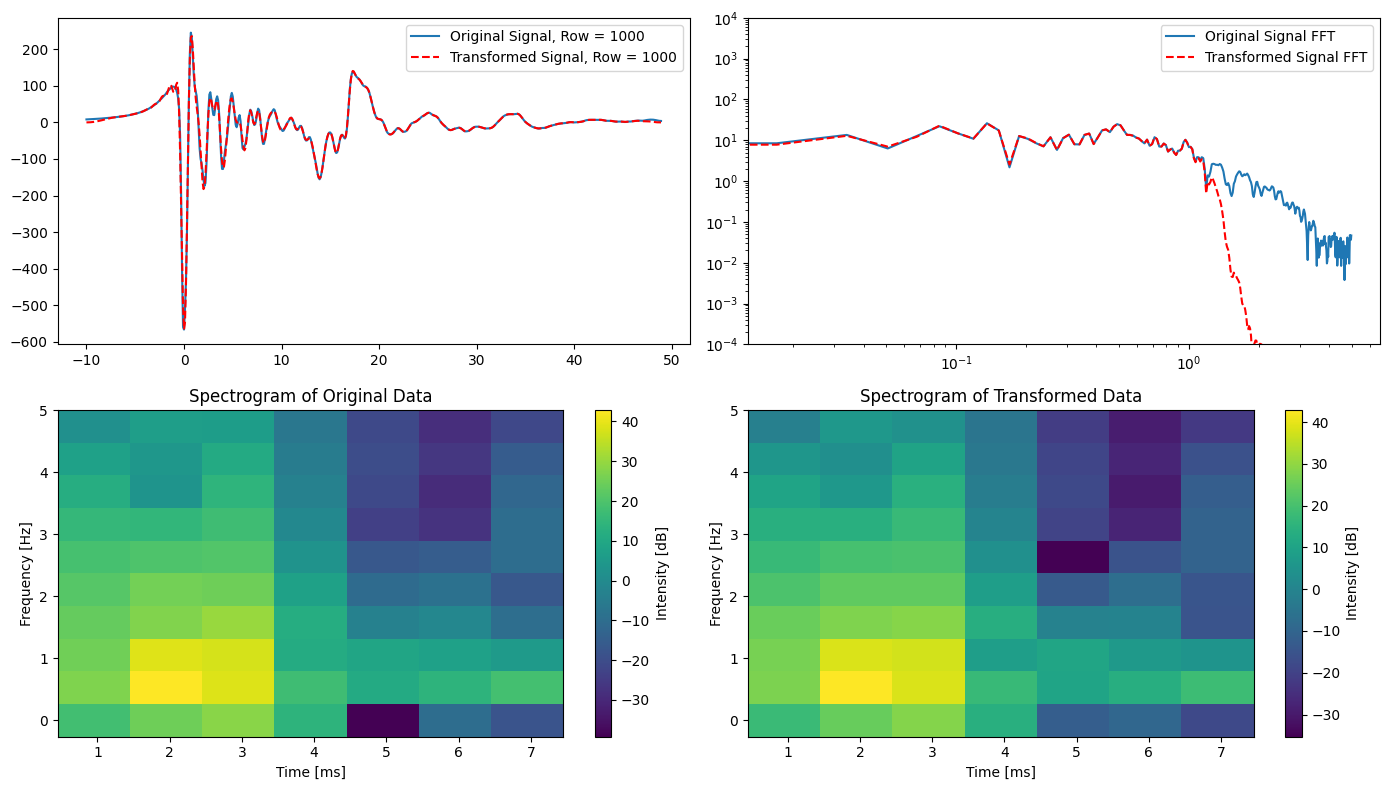

Fourier Transformation Frequency Range:
Min: -5.000000000000195 Hz
Max: 4.983050847457822 Hz

Spectrogram Frequency Range:
Min: 0.0 Hz
Max: 4.736842105263343 Hz


In [7]:
# @title

# 1. Reading the data
midpoint = len(data.columns) // 2

# 2.1 Original Data
time_data = data.iloc[:, :midpoint].mean()
original_data = data.iloc[:, midpoint:-1]  # excluding the label column

# 2.2 Transformed Data
alpha = 0.1
window = windows.tukey(M=original_data.shape[1], alpha=alpha)
windowed_data = original_data.multiply(window, axis=1)
order = 10
attenuation = 0.25
b, a = butter(order, attenuation, btype='low')
filtered_data = windowed_data.apply(lambda x: filtfilt(b, a, x), axis=1)

# Convert the Series to a DataFrame
filtered_data_df = pd.DataFrame(filtered_data.tolist(), columns=time_data.index)

# 3. Fourier transformation for comparison
N = len(time_data)
r = 1000
sample_original = original_data.iloc[r, :]
sample_transformed = filtered_data_df.iloc[r, :]
sample_spectrum1 = 2.0/N * fftshift(fft(sample_original))
sample_spectrum2 = 2.0/N * fftshift(fft(sample_transformed))
sample_frequencies = fftshift(fftfreq(N, d=(time_data[1]-time_data[0])))

# 4. Compute the spectrograms for -2ms to +6ms range
# Extracting the data for the range -2ms to +6ms
start_idx = np.where(time_data >= -2)[0][0]
end_idx = np.where(time_data <= 6)[0][-1]
original_data_range = original_data.iloc[:, start_idx:end_idx]
filtered_data_range = filtered_data_df.iloc[:, start_idx:end_idx]

# Using a smaller window size for the spectrogram to capture the -2ms to +6ms range more effectively
nperseg_value = int((end_idx - start_idx) / 4)  # Using a smaller value for nperseg to increase the resolution

frequencies_range, times_range, Sxx_original_range = spectrogram(original_data_range.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=nperseg_value, noverlap=nperseg_value//2)
_, _, Sxx_transformed_range = spectrogram(filtered_data_range.mean(), fs=1.0/(time_data[1]-time_data[0]), nperseg=nperseg_value, noverlap=nperseg_value//2)



# Plotting
plt.figure(figsize=(14, 8))

# Fourier Transformation plots
plt.subplot(2, 2, 1)
plt.plot(time_data, sample_original, label="Original Signal, Row = %s"%r)
plt.plot(time_data, sample_transformed, linestyle='--', label="Transformed Signal, Row = %s"%r, color='r')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(sample_frequencies, np.abs(sample_spectrum1), label='Original Signal FFT')
plt.plot(sample_frequencies, np.abs(sample_spectrum2), linestyle='--', label='Transformed Signal FFT', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e4)
plt.legend()

# Spectrogram plots
plt.subplot(2, 2, 3)
plt.pcolormesh(times_range, frequencies_range, 10 * np.log10(Sxx_original_range), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Original Data')

plt.subplot(2, 2, 4)
plt.pcolormesh(times_range, frequencies_range, 10 * np.log10(Sxx_transformed_range), shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
plt.title('Spectrogram of Transformed Data')

plt.tight_layout()
plt.show()

# Print out the minimum and maximum of frequency range
print("Fourier Transformation Frequency Range:")
print("Min:", sample_frequencies.min(), "Hz")
print("Max:", sample_frequencies.max(), "Hz")
print("\nSpectrogram Frequency Range:")
print("Min:", frequencies_range.min(), "Hz")
print("Max:", frequencies_range.max(), "Hz")


In [8]:
# @title
# Using the function to calculate the min and max frequencies for each row
midpoint = len(data.columns) // 2
time_data = data.iloc[:, :midpoint].mean()
original_data = data.iloc[:, midpoint:-1]  # excluding the label column

frequency_ranges = original_data.apply(min_max_fft_freqs, axis=1)
frequency_ranges.head()

,Min FFT Frequency,Max FFT Frequency
0,-5.0,4.983051
1,-5.0,4.983051
2,-5.0,4.983051
3,-5.0,4.983051
4,-5.0,4.983051


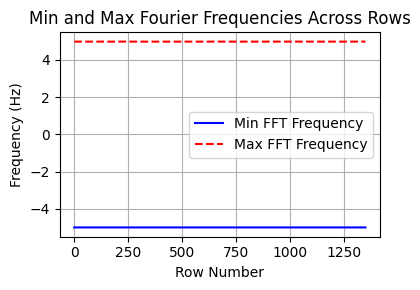

In [9]:
# @title
# Calculate the frequency_ranges
frequency_ranges = original_data.apply(min_max_fft_freqs, axis=1)

# Plot the minimum and maximum Fourier frequencies using a line plot
plt.figure(figsize=(4, 3))
plt.plot(frequency_ranges['Min FFT Frequency'], label='Min FFT Frequency', color='blue')
plt.plot(frequency_ranges['Max FFT Frequency'], label='Max FFT Frequency', color='red', linestyle='--')
plt.xlabel('Row Number')
plt.ylabel('Frequency (Hz)')
plt.title('Min and Max Fourier Frequencies Across Rows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load the data
df = fourier_df_with_freq

# Drop the first row (frequency values) and preprocess
df_transformed = df.drop(0)
df_transformed.iloc[:, :-1] = df_transformed.iloc[:, :-1].astype(float)
df_transformed['Label'] = df_transformed['Label'].astype(str)

# Set the input shape for the model
shape = df_transformed.shape[1]-1
input_shape = (shape, 1)

# Define the neural network model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(18, activation='softmax')  # Adjust number of classes if needed
])

model.compile(optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Convert the labels to integer encoding
labels_integer_encoded = pd.factorize(df_transformed['Label'])[0]

# Reshape the data
reshaped_data = df_transformed.iloc[:, :-1].values.reshape(-1, shape, 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, labels_integer_encoded, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
34/34 [==============================] - 6s 151ms/step - loss: 2.9425 - accuracy: 0.0639 - val_loss: 2.8803 - val_accuracy: 0.0926
Epoch 2/10
34/34 [==============================] - 5s 151ms/step - loss: 2.8466 - accuracy: 0.0759 - val_loss: 2.7602 - val_accuracy: 0.1074
Epoch 3/10
34/34 [==============================] - 4s 119ms/step - loss: 2.6678 - accuracy: 0.1204 - val_loss: 2.5412 - val_accuracy: 0.1556
Epoch 4/10
34/34 [==============================] - 7s 209ms/step - loss: 2.4462 - accuracy: 0.1583 - val_loss: 2.4062 - val_accuracy: 0.1704
Epoch 5/10
34/34 [==============================] - 5s 151ms/step - loss: 2.2456 - accuracy: 0.2204 - val_loss: 2.1577 - val_accuracy: 0.2481
Epoch 6/10
34/34 [==============================] - 5s 134ms/step - loss: 2.0352 - accuracy: 0.2676 - val_loss: 2.2200 - val_accuracy: 0.2185
Epoch 7/10
34/34 [==============================] - 5s 162ms/step - loss: 1.8919 - accuracy: 0.2972 - val_loss: 1.9395 - val_accuracy: 0.2148
Epoch 

In [89]:
df = fourier_df_with_trans

# Drop the first row (frequency values) and preprocess
df_transformed = df.drop(0)
df_transformed.iloc[:, :-1] = df_transformed.iloc[:, :-1].astype(float)
df_transformed['Label'] = df_transformed['Label'].astype(str)

# Convert the labels to integer encoding
labels_integer_encoded = pd.factorize(df_transformed['Label'])[0]


# Get the frequency values from the first row
frequencies = df.iloc[0, :-1].values.astype(float)

# Repeat the frequency values for each sample
frequencies_repeated = np.tile(frequencies, (df_transformed.shape[0], 1))

# Stack the frequencies alongside the magnitude values to create a 2D array for each sample
combined_data = np.stack((frequencies_repeated, df_transformed.iloc[:, :-1].values), axis=-1)

# Adjust the input shape for the model
input_shape_combined = (shape, 2)

# Define the modified neural network model
model_combined = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape_combined),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(18, activation='softmax')  # Adjust number of classes if needed
])

model_combined.compile(optimizer='RMSProp',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Split the data into train and test sets for the combined data
X_train_combined, X_test_combined, _, _ = train_test_split(combined_data, labels_integer_encoded, test_size=0.2, random_state=42)

# Train the model with combined data
history_combined = model_combined.fit(X_train_combined, y_train, epochs=20, validation_data=(X_test_combined, y_test))

# Evaluate the model with combined data
test_loss_combined, test_acc_combined = model_combined.evaluate(X_test_combined, y_test, verbose=2)
print('\nTest accuracy with combined data:', test_acc_combined)


Epoch 1/20
34/34 [==============================] - 7s 151ms/step - loss: 3.0255 - accuracy: 0.0491 - val_loss: 2.8859 - val_accuracy: 0.0630
Epoch 2/20
34/34 [==============================] - 4s 113ms/step - loss: 2.8685 - accuracy: 0.0796 - val_loss: 2.8125 - val_accuracy: 0.1074
Epoch 3/20
34/34 [==============================] - 5s 147ms/step - loss: 2.7362 - accuracy: 0.1056 - val_loss: 2.6247 - val_accuracy: 0.1185
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 2.5156 - accuracy: 0.1556 - val_loss: 2.4718 - val_accuracy: 0.1593
Epoch 5/20
34/34 [==============================] - 4s 128ms/step - loss: 2.2958 - accuracy: 0.2157 - val_loss: 2.2769 - val_accuracy: 0.2148
Epoch 6/20
34/34 [==============================] - 6s 167ms/step - loss: 2.1031 - accuracy: 0.2435 - val_loss: 2.1109 - val_accuracy: 0.2259
Epoch 7/20
34/34 [==============================] - 5s 131ms/step - loss: 1.9241 - accuracy: 0.2852 - val_loss: 1.9997 - val_accuracy: 0.2148
Epoch 

9/9 [==============================] - 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 1s 76ms/step


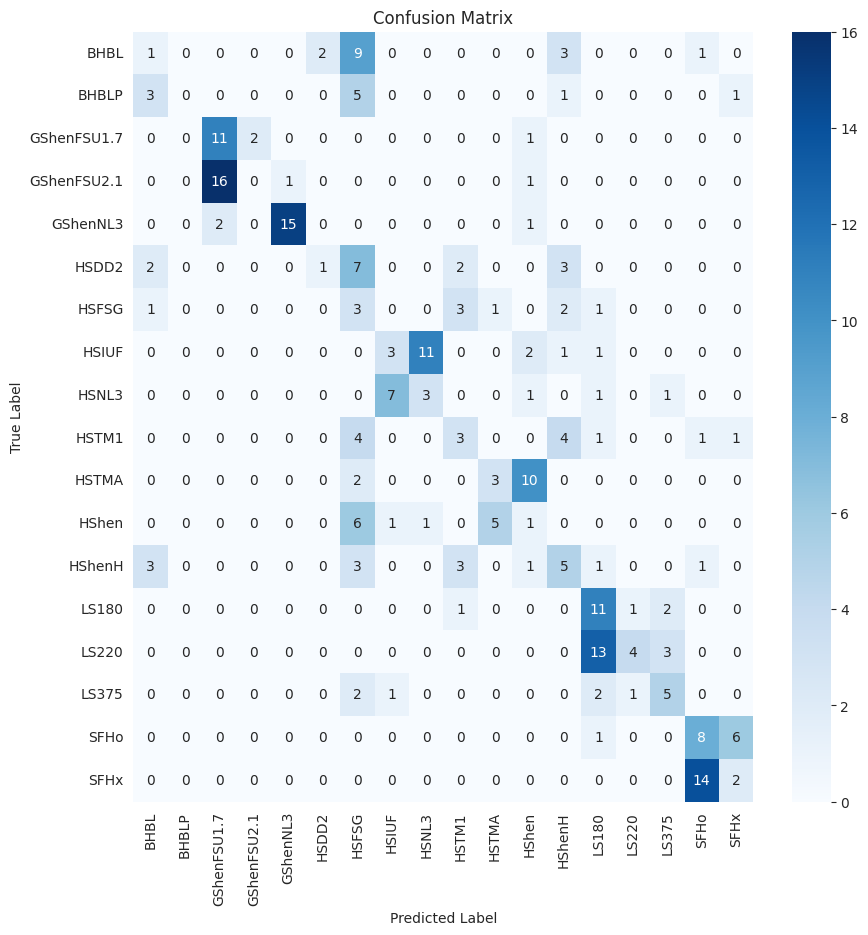

Accuracy: 0.29259259259259257
Precision: 0.2866846285947828
Recall: 0.29135675054792703
F1 Score: 0.2620500776039798


In [93]:
# Get predicted labels
predictions = np.argmax(model_combined.predict(X_test_combined), axis=-1)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Initialize the encoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers
# Assuming 'df' is your original DataFrame and 'Label' is the column with labels
encoder.fit(df_transformed['Label'])

#class_names = encoder.classes_

# Assuming 'y_test' is your test labels and 'model' is your trained model
predictions = model_combined.predict(X_test_combined)
predictions_indices = np.argmax(predictions, axis=1)

# Get class names from the label encoder
class_names = encoder.classes_

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions_indices)

# Convert numerical labels back to original names for plotting
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

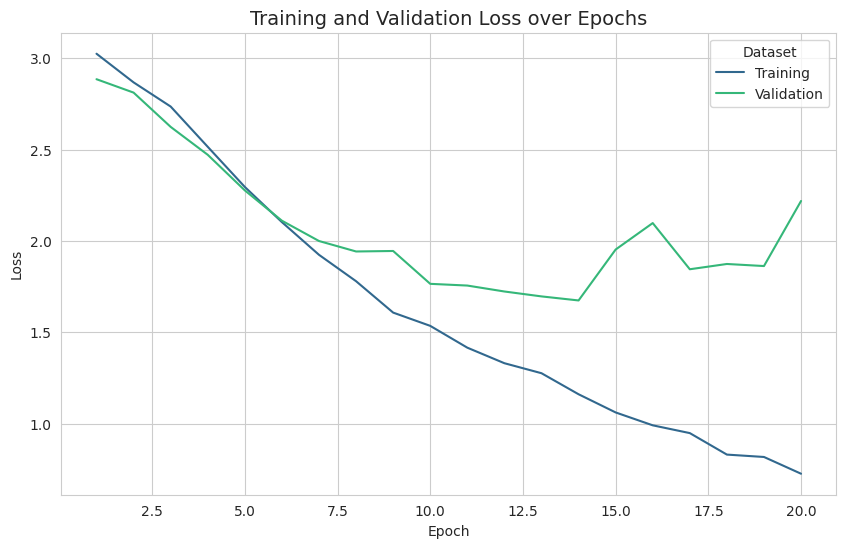

In [95]:
# Prepare data in DataFrame format
data = pd.DataFrame({
    'Epoch': list(range(1, len(history_combined.history['loss']) + 1)) * 2,
    'Loss': history_combined.history['loss'] + history_combined.history['val_loss'],
    'Dataset': ['Training'] * len(history_combined.history['loss']) + ['Validation'] * len(history_combined.history['val_loss'])
})

# Create lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', hue='Dataset', data=data, palette='viridis')

# Add a title
plt.title('Training and Validation Loss over Epochs', fontsize=14)

plt.show()